# Training a FFNN in dCGPANN vs. Keras (classification)

A Feed Forward Neural network is a widely used ANN model for regression and classification. Here we show how to encode it into a dCGPANN and train it with stochastic gradient descent on a regression task. To check the correctness of the result we perform the same training using the widely used Keras Deep Learning toolbox.

In [1]:
# Initial import
import dcgpy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle
import timeit

%matplotlib inline

### Data set

In [2]:
# We import the data for a classification task.
from numpy import genfromtxt
# https://archive.ics.uci.edu/ml/datasets/Abalone
my_data = genfromtxt('abalone_data_set.csv', delimiter=',')
points = my_data[:,:-1]
labels_tmp = my_data[:,-1]

# We trasform the categorical variables to one hot encoding
# The problem is treated as a three class problem
labels = np.zeros((len(labels_tmp), 3))
for i,l in enumerate(labels_tmp):
    if l < 9:
        labels[i][0] = 1
    elif l > 10:
        labels[i][2] = 1
    else :
        labels[i][1] = 1

# And split the data into training and test
X_train = points[:3000]
Y_train = labels[:3000]
X_test = points[3000:]
Y_test = labels[3000:]


In [3]:
# Stable implementation of the softmax function
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# We define the accuracy metric
def accuracy(ex, points, labels):
    acc = 0.
    for p,l in zip(points, labels):
        ps = softmax(ex(p))
        if np.argmax(ps) == np.argmax(l):
            acc += 1.
    return acc / len(points)

### Encoding and training a FFNN using dCGP

There are many ways the same FFNN could be encoded into a CGP chromosome. The utility *encode_ffnn* selects one for you returning the expression.

In [4]:
# We encode a FFNN into a dCGP expression. Note that the last layer is made by a sum activation function
# so that categorical cross entropy can be used and produce a softmax activation last layer. 
# In a dCGP the concept of layers is absent and neurons are defined by activation functions R->R.
dcgpann = dcgpy.encode_ffnn(8,3,[50,20],["sig", "sig", "sum"], 5)

# By default all weights (and biases) are set to 1 (and 0). We initialize the weights normally distributed
dcgpann.randomise_weights(mean = 0., std = 1.)
dcgpann.randomise_biases(mean = 0., std = 1.)


print("Starting error:", dcgpann.loss(X_test,Y_test, "CE"))
print("Net complexity (number of active weights):", dcgpann.n_active_weights())
print("Net complexity (number of unique active weights):", dcgpann.n_active_weights(unique=True))
print("Net complexity (number of active nodes):", len(dcgpann.get_active_nodes()))

#dcgpann.visualize(show_nonlinearities=True, legend=True)

Starting error: 1.5061347488465693
Net complexity (number of active weights): 1460
Net complexity (number of unique active weights): 1460
Net complexity (number of active nodes): 81


In [5]:
res = []

# We train
n_epochs = 100
print("Start error (training set):", dcgpann.loss(X_train,Y_train, "CE"), flush=True)
print("Start error (test):", dcgpann.loss(X_test,Y_test, "CE"), flush=True)

start_time = timeit.default_timer()
for i in tqdm(range(n_epochs)):
    res.append(dcgpann.sgd(X_train, Y_train, 1., 32, "CE", parallel = 4))
elapsed = timeit.default_timer() - start_time

print("End error (training set):", dcgpann.loss(X_train,Y_train, "CE"), flush=True)
print("End error (test):", dcgpann.loss(X_test,Y_test, "CE"), flush=True)
print("Time:", elapsed, flush=True)





Start error (training set): 1.4720344086582846
Start error (test): 1.5061347488465693


100%|██████████| 100/100 [00:03<00:00, 25.93it/s]


End error (training set): 0.7208024932769636
End error (test): 0.746330466571727
Time: 3.8610038610058837


Accuracy (test):  0.6482582837723024


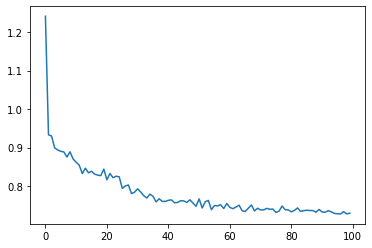

In [6]:
plt.plot(res)
print("Accuracy (test): ", accuracy(dcgpann, X_test, Y_test))

### Same training is done using Keras (Tensor Flow backend)
IMPORTANT: no GPU is used for the comparison. The values are thus only to be taken as indications of the performances on a simple environment with 4 CPUs.

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

# We define Stochastic Gradient Descent as an optimizer
sgd = optimizers.SGD(lr=1.)
# We define weight initializetion
initializerw = keras.initializers.RandomNormal(mean=0.0, stddev=1, seed=None)
initializerb = keras.initializers.RandomNormal(mean=0.0, stddev=1, seed=None)

model = Sequential([
    Dense(50, input_dim=8, kernel_initializer=initializerw, bias_initializer=initializerb),
    Activation('sigmoid'),
    Dense(20, kernel_initializer=initializerw, bias_initializer=initializerb),
    Activation('sigmoid'),
    Dense(3, kernel_initializer=initializerw, bias_initializer=initializerb),
    Activation('softmax'),
])
model.compile(optimizer=sgd,
              loss='categorical_crossentropy', metrics=['acc'])


Using TensorFlow backend.


In [8]:
start_time = timeit.default_timer()
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=False)
elapsed = timeit.default_timer() - start_time
print("End error (training set):", model.evaluate(X_train,Y_train, verbose=False))
print("End error (test):", model.evaluate(X_test,Y_test, verbose=False))
print("Time:", elapsed)

End error (training set): [0.7347922405401865, 0.6513333320617676]
End error (test): [0.768989267041345, 0.6295666694641113]
Time: 12.229093839996494


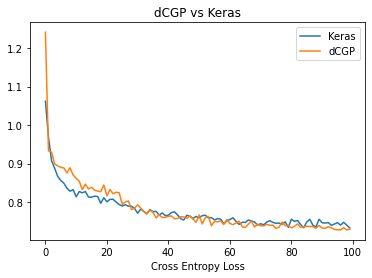

In [9]:
# We plot for comparison the MSE during learning in the two cases
plt.plot(history.history['loss'], label='Keras')
plt.plot(res, label='dCGP')
plt.title('dCGP vs Keras')
plt.xlabel('epochs')
plt.legend()
_ = plt.xlabel('Cross Entropy Loss')